In [39]:
# Installing `caer` and `canaro` since they don't come pre-installed
!pip install --upgrade caer canaro

In [40]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc
#pylint:disable=no-member (Removes linting problems with cv)

In [41]:
!pip install kagglehub


In [42]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [43]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/alexattia/the-simpsons-characters-dataset/versions/4


In [44]:
IMG_SIZE = (80,80)
channels = 1
char_path = path

In [45]:
import os
import caer

# Update the path to point to the correct directory
dataset_path = "/root/.cache/kagglehub/datasets/alexattia/the-simpsons-characters-dataset/versions/4"
char_path = os.path.join(dataset_path, "simpsons_dataset")  # This is the correct directory

# Create character dictionary
char_dict = {}

if os.path.isdir(char_path):
    for char in os.listdir(char_path):
        char_folder = os.path.join(char_path, char)
        if os.path.isdir(char_folder):  # Make sure we're only processing directories
            char_dict[char] = len(os.listdir(char_folder))

    # Sort in descending order
    char_dict = caer.sort_dict(char_dict, descending=True)
    print("Successfully processed character directories!")
else:
    print(f"Error: Directory not found at {char_path}")
    print("Available contents in dataset directory:")
    print(os.listdir(dataset_path))

Successfully processed character directories!


In [46]:
#  Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [47]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.006006717681884766s
[INFO] At 1000 files
[INFO] 1454 files found in 0.011246204376220703s
[INFO] At 1000 files
[INFO] 1452 files found in 0.003141641616821289s
[INFO] At 1000 files
[INFO] 1354 files found in 0.0031135082244873047s
[INFO] At 1000 files
[INFO] 1342 files found in 0.002819538116455078s
[INFO] At 1000 files
[INFO] 1291 files found in 0.0029036998748779297s
[INFO] At 1000 files
[INFO] 1206 files found in 0.0026924610137939453s
[INFO] At 1000 files
[INFO] 1194 files found in 0.0031309127807617188s
[INFO] At 1000 files
[INFO] 1193 files found in 0.005471706390380859s
[INFO] At 1000 files
[INFO] 1079 files found in 0.0050890445709228516s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 21s


In [48]:
# Number of training samples
len(train)

13811

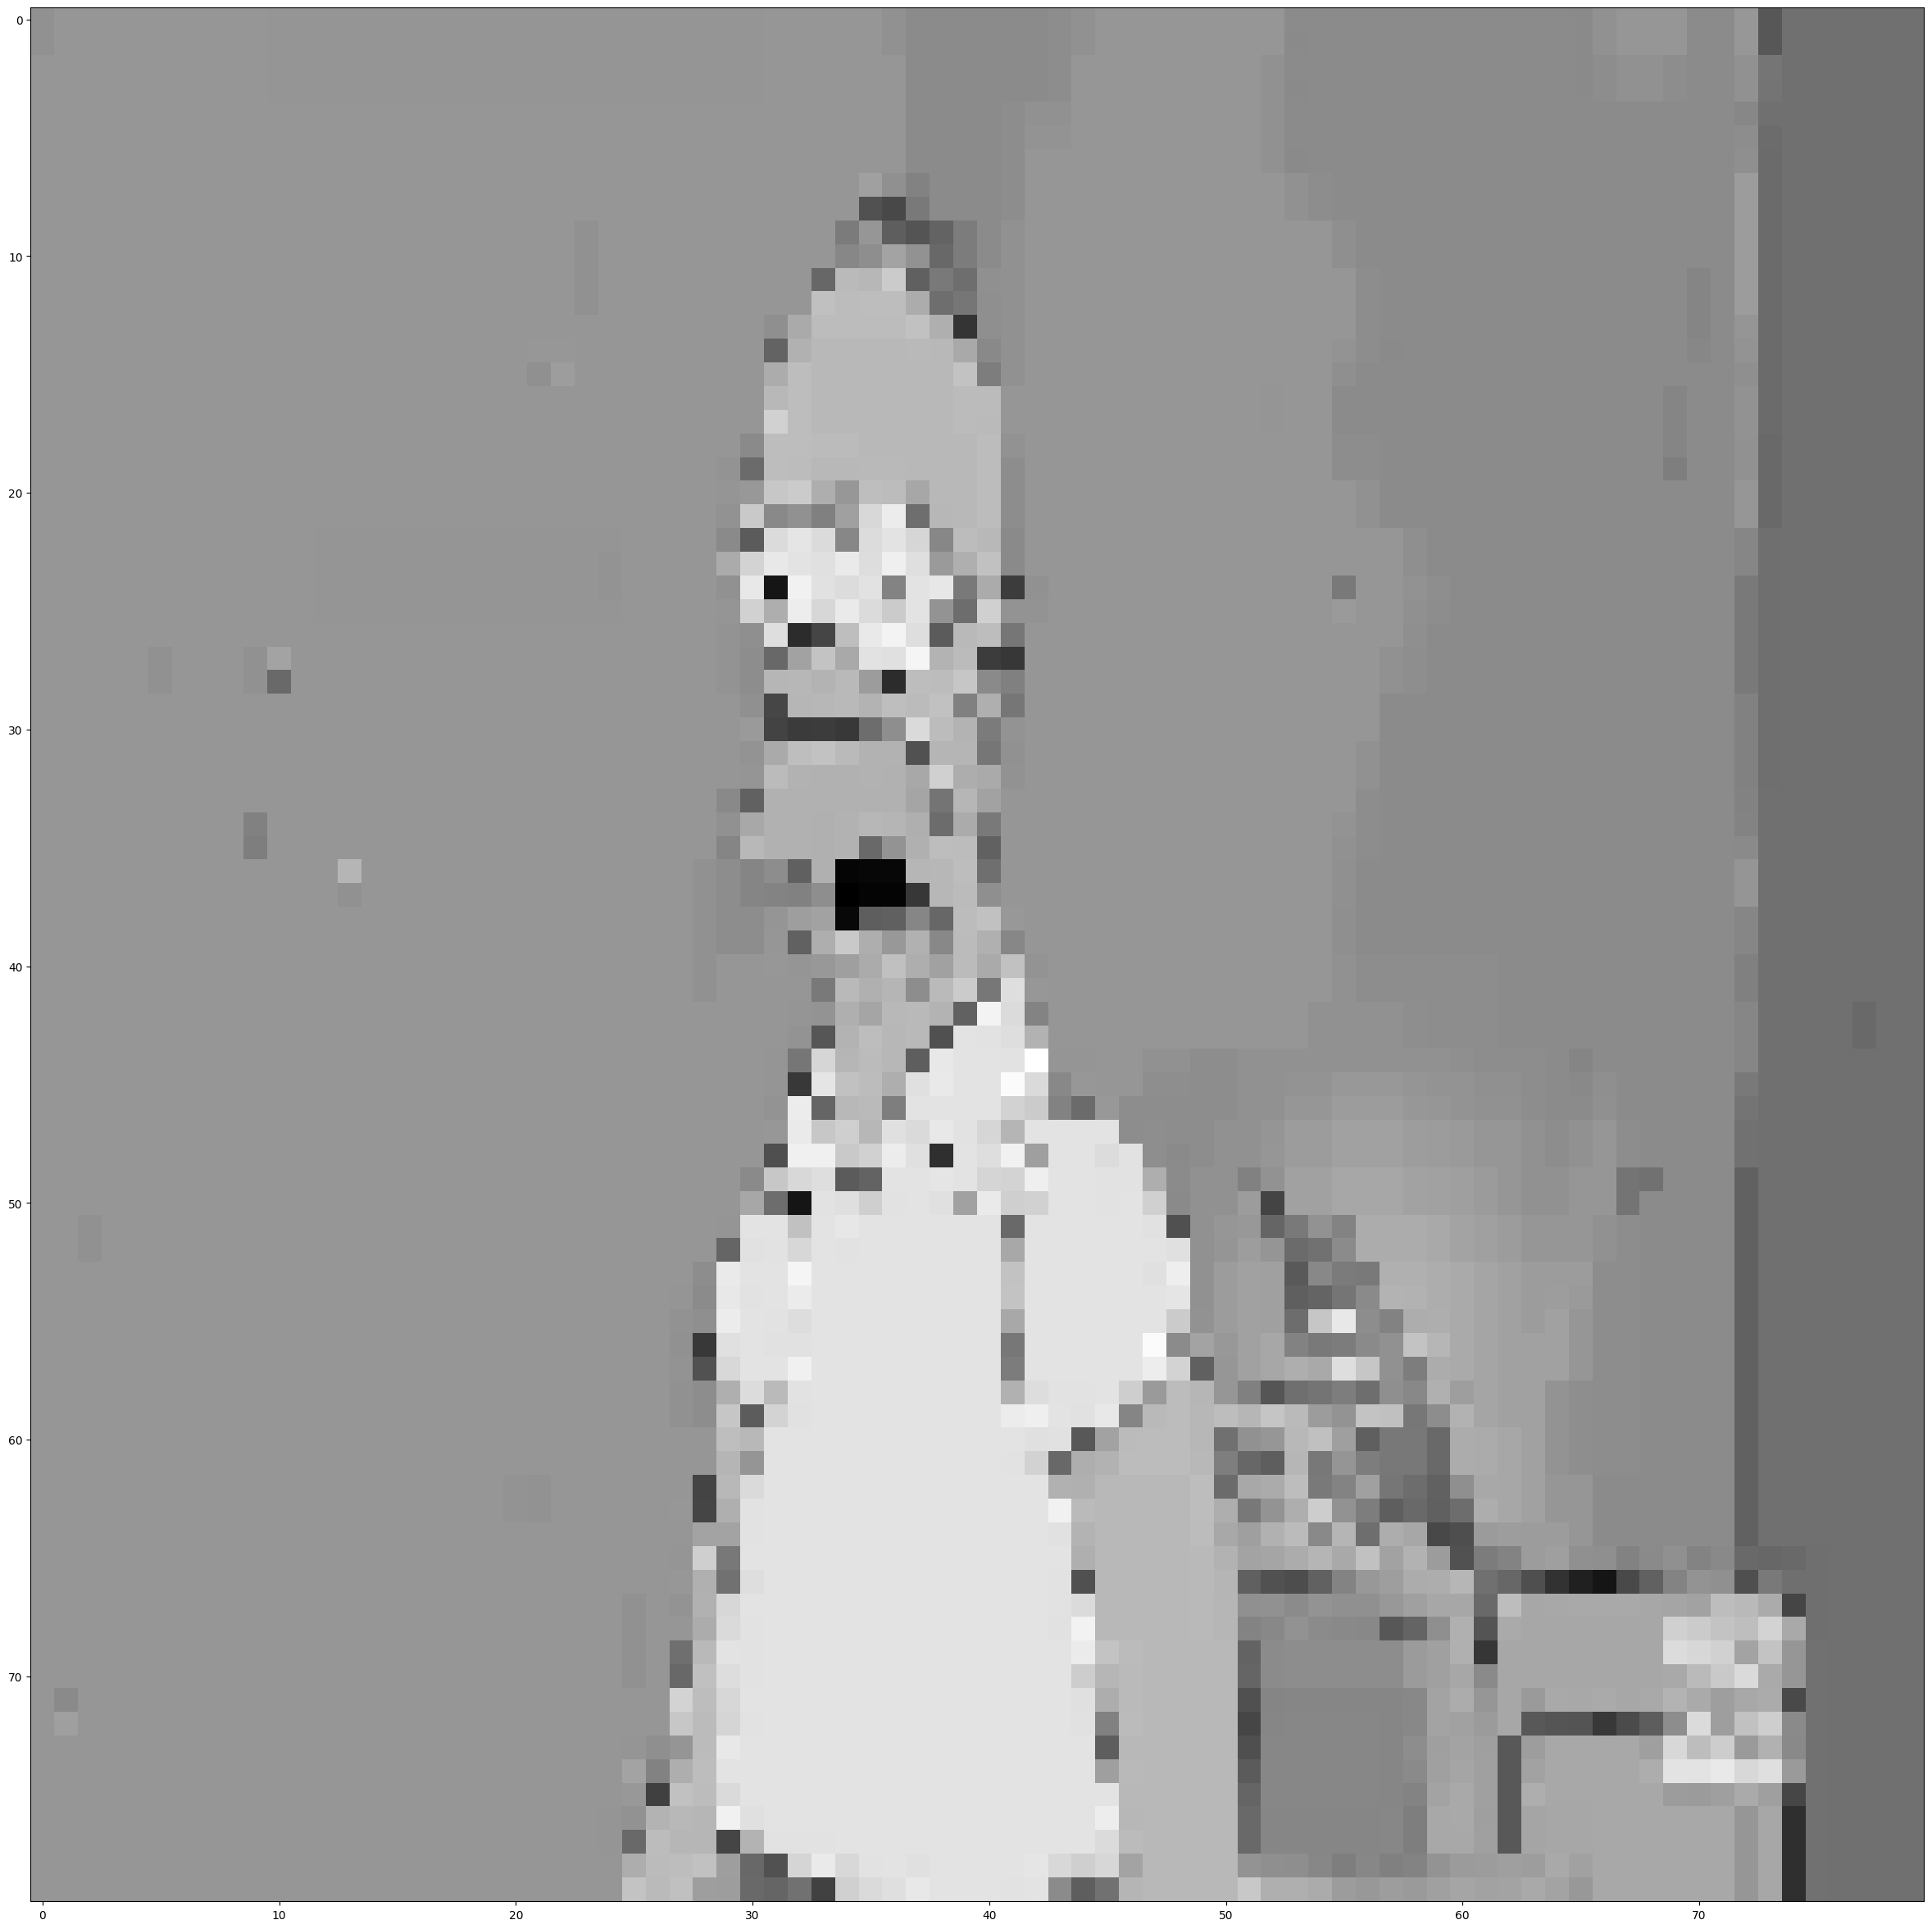

In [49]:
# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [50]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [51]:
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

In [52]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [54]:
# Check if variables exist before deleting
for var in ['train', 'featureSet', 'labels']:
    if var in locals():
        print(f"Deleting {var}")
        exec(f"del {var}")

# Run garbage collection
import gc
collected = gc.collect()
print(f"Garbage collector collected {collected} objects")

Garbage collector collected 0 objects


In [55]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

In [56]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [57]:
# Create our model (returns a compiled model)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

output_dim=10

w, h = IMG_SIZE[:2]

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h,channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))

# Output Layer
model.add(Dense(output_dim, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 80, 80, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 78, 78, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 39, 39, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 18, 18, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │      16,778,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,591,274 (67.11 MB)

 Trainable params: 17,591,274 (67.11 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
from keras.optimizers import SGD

optimizer = SGD(
    learning_rate=0.001,
    momentum=0.9,
    nesterov=True,
    weight_decay=1e-7  # 'decay' is now 'weight_decay' in new versions
)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [60]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.1534 - loss: 0.3861 - val_accuracy: 0.1617 - val_loss: 0.3341 - learning_rate: 0.0100
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2188 - loss: 0.3218 - val_accuracy: 0.1617 - val_loss: 0.3339 - learning_rate: 0.0100
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.1631 - loss: 0.3236 - val_accuracy: 0.1617 - val_loss: 0.3329 - learning_rate: 0.0100
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2500 - loss: 0.3179 - val_accuracy: 0.1617 - val_loss: 0.3326 - learning_rate: 0.0100
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.1596 - loss: 0.3235 - val_accuracy: 0.1617 - val_loss: 0.3348 - learning_rate: 0.0100
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2188 - loss: 0.3215 - val_accuracy: 0.1617 - val_loss: 0.3350 - learning_rate: 0.0100
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.1726 - loss: 0

In [61]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

## Testing

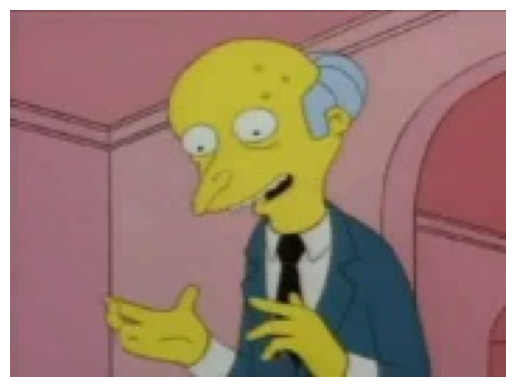

In [66]:
import cv2 as cv
import matplotlib.pyplot as plt
import os

# Corrected path - removing the duplicate directory name
base_path = "/root/.cache/kagglehub/datasets/alexattia/the-simpsons-characters-dataset/versions/4"
test_path = os.path.join(base_path, "kaggle_simpson_testset", "kaggle_simpson_testset", "charles_montgomery_burns_1.jpg")

# Read and display the image
img = cv.imread(test_path)

if img is not None:
    # Convert BGR to RGB for correct color display using cv instead of cv2
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print(f"Error: Could not read image at {test_path}")
    print("Checking if file exists:", os.path.exists(test_path))
    print("\nAvailable files in test directory:")
    test_dir = os.path.join(base_path, "kaggle_simpson_testset", "kaggle_simpson_testset")
    if os.path.exists(test_dir):
        print(os.listdir(test_dir))

In [67]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [68]:
predictions = model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [69]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

lisa_simpson
